In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sqlalchemy import create_engine

# Connect to PostgreSQL
db_uri = {db_uri}
engine = create_engine(db_uri)

# Fetch influencer-category data
query = """
SELECT influencer_id, username, string_to_array(category, ', ') AS categories
FROM influencers
WHERE category IS NOT NULL AND category <> '';
"""
df = pd.read_sql(query, engine)
engine.dispose()

# Explode multi-category influencers into separate rows
df = df.explode("categories")

# Count the number of categories per influencer
df["category_count"] = df.groupby("influencer_id")["categories"].transform("count")

# Preview data
print(df.head())


   influencer_id       username categories  category_count
0              2      soshewore   interior               2
0              2      soshewore       food               2
1            123       chxrming        pet               2
1            123       chxrming       food               2
2            242  lepetitbeirut     beauty               2


In [4]:
# Find influencers with multiple categories
multi_category_influencers = df[df["category_count"] > 1]

# Get top influencers spanning the most categories
top_cross_niche = multi_category_influencers.groupby("username")["category_count"].max().sort_values(ascending=False).head(10)

print("🔹 Top 10 Cross-Niche Influencers:")
print(top_cross_niche)

🔹 Top 10 Cross-Niche Influencers:
username
zuzanastraska    3
zuccaviolina     3
0paline          3
zsuzsubell       3
zsofistein       3
17maggiezine     3
zenandspice      3
zenassuitcase    3
zestmylemon      3
zestysups        3
Name: category_count, dtype: int64


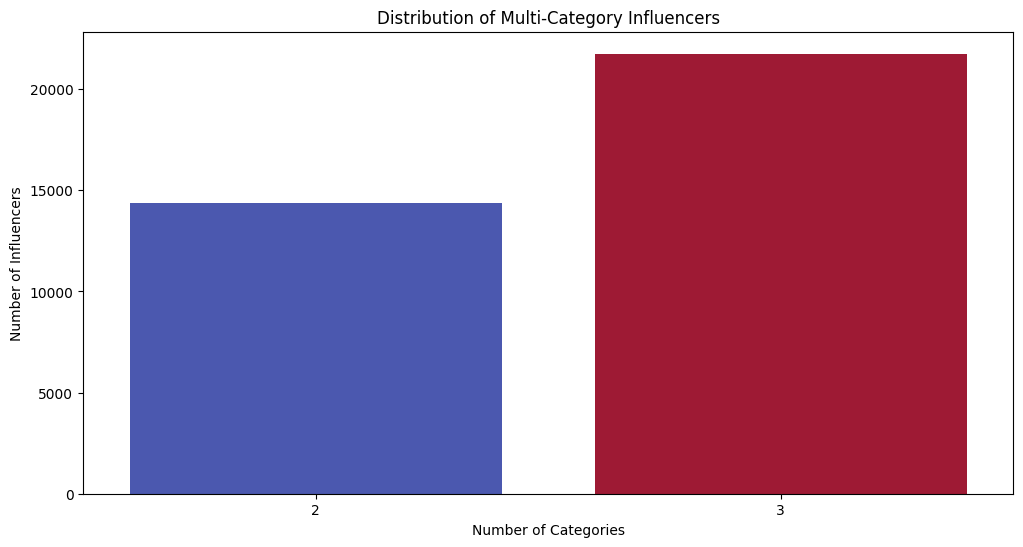

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(data=multi_category_influencers, x="category_count", hue="category_count", palette="coolwarm", legend=False)

plt.xlabel("Number of Categories")
plt.ylabel("Number of Influencers")
plt.title("Distribution of Multi-Category Influencers")
plt.show()

In [12]:
# Keep influencers that have at least 2 categories
multi_category_influencers = df[df["category_count"] > 1]

# Ensure no filtering removes too many nodes
top_influencers = multi_category_influencers["username"].unique()
top_categories = multi_category_influencers["categories"].unique()

# Create a new graph with only multi-category influencers
G_filtered = nx.Graph()

# Add influencers and categories as nodes
for influencer in top_influencers:
    G_filtered.add_node(influencer, type="influencer")

for category in top_categories:
    G_filtered.add_node(category, type="category")

# Add edges between influencers and categories
for _, row in multi_category_influencers.iterrows():
    G_filtered.add_edge(row["username"], row["categories"])

# Check if the graph has nodes
if len(G_filtered.nodes) == 0:
    print("⚠️ No multi-category influencers found. Check if category data is formatted correctly.")

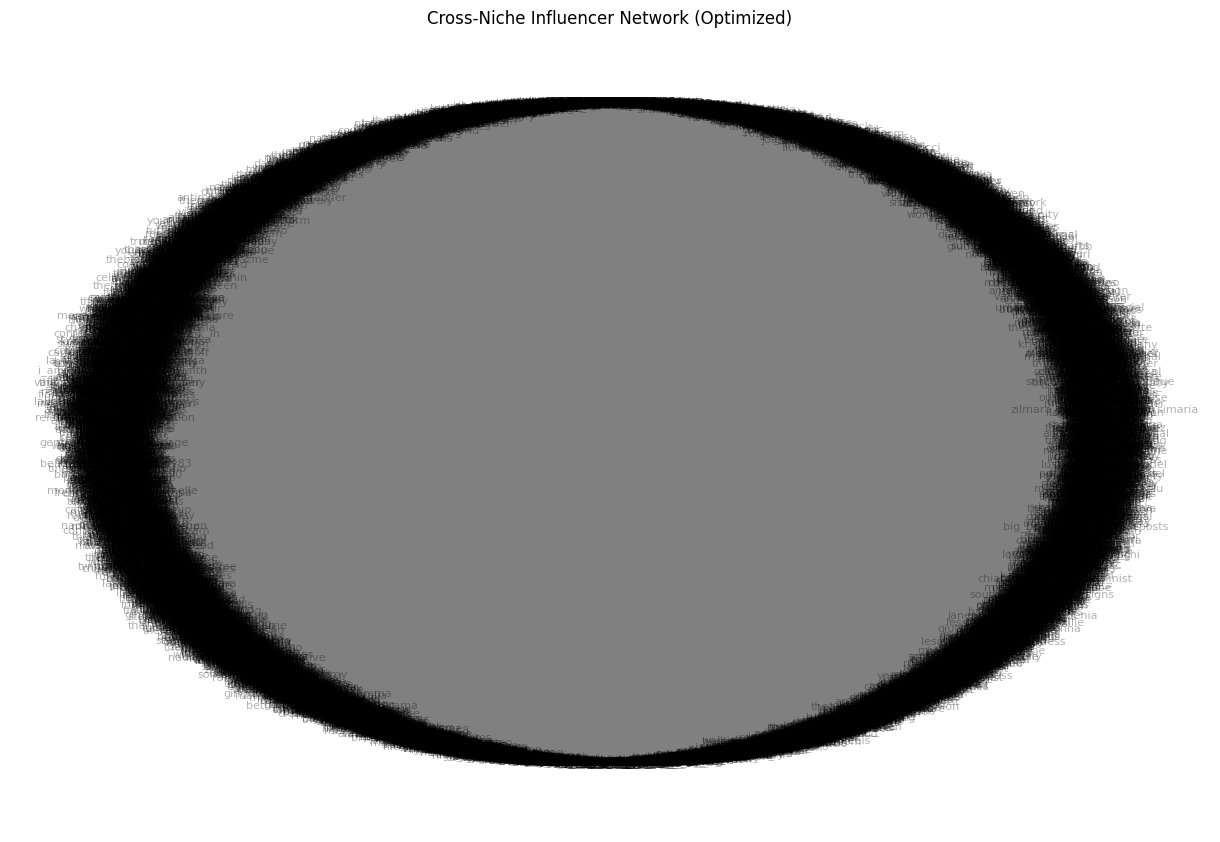

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

if len(G_filtered.nodes) > 0:
    # Compute degree centrality for node sizes
    degree_centrality = nx.degree_centrality(G_filtered)
    node_sizes = [degree_centrality[node] * 2000 for node in G_filtered.nodes()]

    # Assign colors: Influencers = Blue, Categories = Red
    node_colors = ["skyblue" if G_filtered.nodes[n]["type"] == "influencer" else "lightcoral" for n in G_filtered.nodes()]

    # Use shell layout for better structure
    pos = nx.shell_layout(G_filtered)

    # Plot the improved graph
    plt.figure(figsize=(12, 8))
    nx.draw(G_filtered, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, edge_color="gray", alpha=0.3, font_size=8)

    plt.title("Cross-Niche Influencer Network (Optimized)")
    plt.show()
else:
    print("⚠️ No influencers meet the criteria. Check category data.")

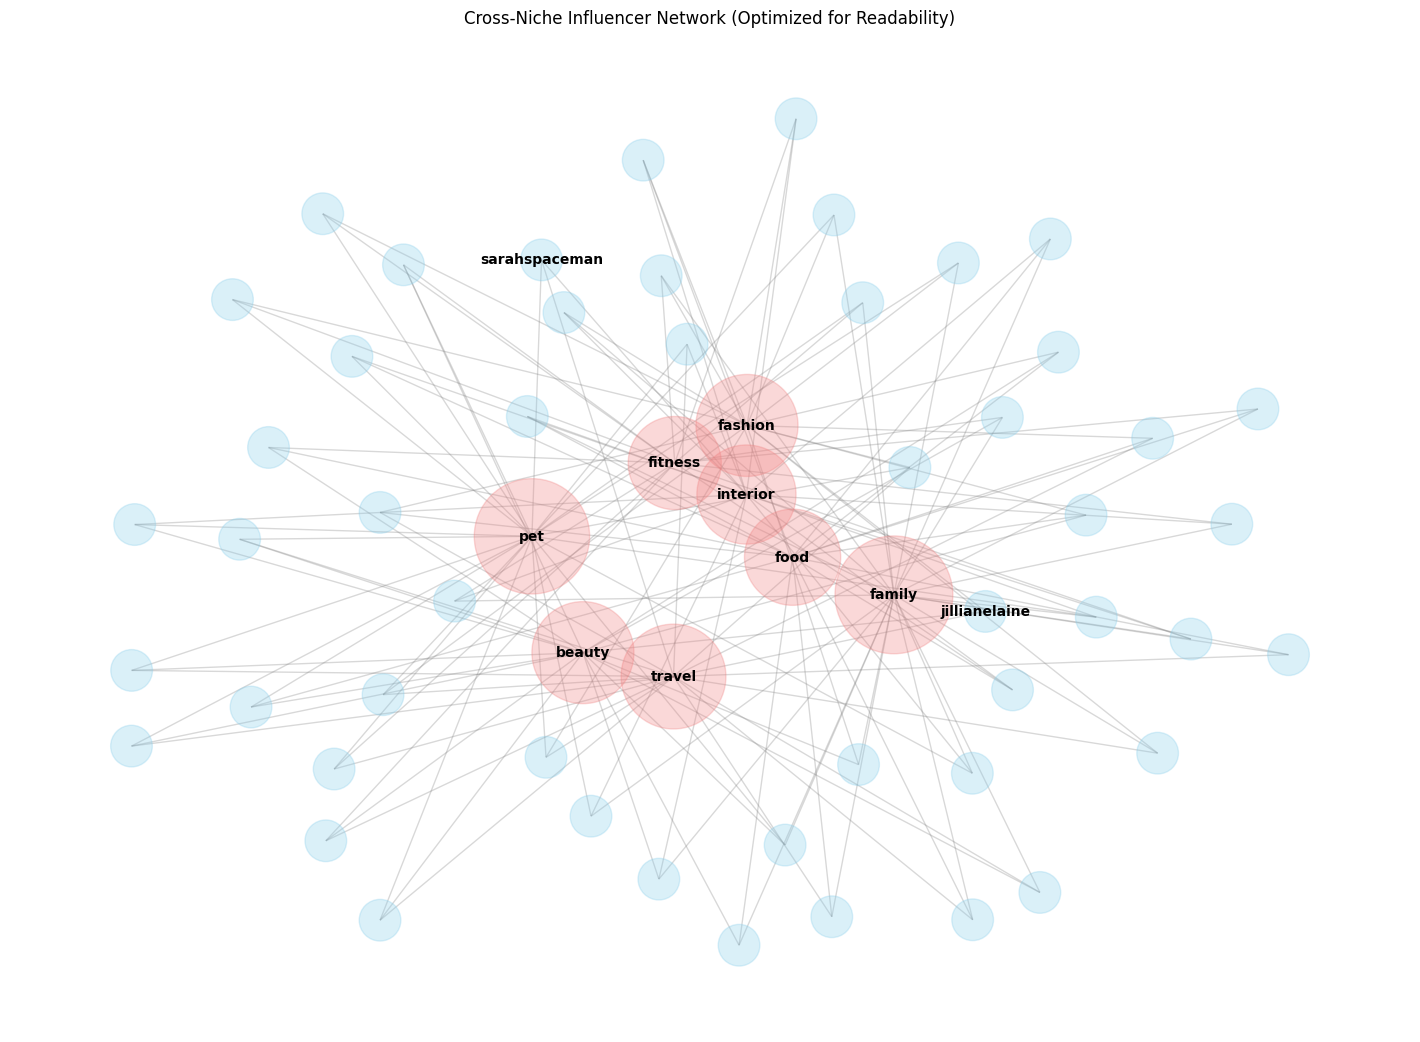

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Filter Only Top Influencers & Categories
top_influencers = multi_category_influencers["username"].value_counts().head(50).index
top_categories = multi_category_influencers["categories"].value_counts().head(10).index

# Create a new filtered graph
G_filtered = nx.Graph()

# Add influencers and categories as nodes
for influencer in top_influencers:
    G_filtered.add_node(influencer, type="influencer")

for category in top_categories:
    G_filtered.add_node(category, type="category")

# Add edges between influencers and their categories
for _, row in multi_category_influencers.iterrows():
    if row["username"] in top_influencers and row["categories"] in top_categories:
        G_filtered.add_edge(row["username"], row["categories"])

# Step 2: Compute Node Sizes Based on Degree
degree_dict = dict(G_filtered.degree())
node_sizes = [degree_dict[node] * 300 for node in G_filtered.nodes()]

# Step 3: Assign Different Colors for Influencers & Categories
node_colors = ["skyblue" if G_filtered.nodes[n]["type"] == "influencer" else "lightcoral" for n in G_filtered.nodes()]

# Step 4: Use Fruchterman-Reingold Layout (Spring Layout) for Better Spacing
pos = nx.spring_layout(G_filtered, seed=42, k=0.8, iterations=50)

# Step 5: Draw Graph
plt.figure(figsize=(14, 10))
nx.draw(G_filtered, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, edge_color="gray", alpha=0.3)

# Step 6: Label Only the Top 10 Most Connected Nodes for Readability
top_labels = sorted(degree_dict, key=degree_dict.get, reverse=True)[:10]
labels = {node: node for node in top_labels}
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=10, font_weight="bold")

plt.title("Cross-Niche Influencer Network (Optimized for Readability)")
plt.show()

In [15]:
# Step 1: Count Multi-Category Influencers
total_influencers = df["influencer_id"].nunique()
multi_category_influencers = df[df["category_count"] > 1]
multi_category_count = multi_category_influencers["influencer_id"].nunique()
multi_category_percentage = (multi_category_count / total_influencers) * 100

print(f"🔹 Total Influencers: {total_influencers}")
print(f"🔹 Multi-Category Influencers: {multi_category_count} ({multi_category_percentage:.2f}%)\n")

# Step 2: Find Most Common Category Combinations
category_combinations = multi_category_influencers.groupby("influencer_id")["categories"].apply(lambda x: ", ".join(sorted(x.unique())))
top_category_combinations = category_combinations.value_counts().head(10)

print("🔹 Top 10 Most Common Cross-Niche Combinations:")
print(top_category_combinations, "\n")

# Step 3: Identify Most Diversified Influencers (Highest Category Count)
top_diverse_influencers = multi_category_influencers.groupby("username")["categories"].nunique().sort_values(ascending=False).head(10)

print("🔹 Top 10 Most Diversified Influencers (Most Categories Covered):")
print(top_diverse_influencers, "\n")

# Step 4: Identify Categories with the Most Cross-Influence
category_connections = df.groupby("categories")["influencer_id"].nunique().sort_values(ascending=False).head(10)

print("🔹 Top 10 Most Cross-Connected Categories:")
print(category_connections, "\n")

# Step 5: Find Influencers Who Connect the Most Different Categories (Bridges)
from collections import Counter

category_counts = Counter(multi_category_influencers["categories"])
category_bridges = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("🔹 Top 10 Categories Spanning the Most Influencers:")
for category, count in category_bridges:
    print(f"{category}: {count} influencers")

🔹 Total Influencers: 25823
🔹 Multi-Category Influencers: 14445 (55.94%)

🔹 Top 10 Most Common Cross-Niche Combinations:
categories
beauty, fitness     288
pet, travel         273
beauty, family      270
beauty, fashion     268
fitness, food       268
interior, pet       268
family, pet         268
beauty, travel      267
fitness, pet        265
fashion, fitness    265
Name: count, dtype: int64 

🔹 Top 10 Most Diversified Influencers (Most Categories Covered):
username
zuzanastraska    3
zuccaviolina     3
0paline          3
zsuzsubell       3
zsofistein       3
17maggiezine     3
zenandspice      3
zenassuitcase    3
zestmylemon      3
zestysups        3
Name: categories, dtype: int64 

🔹 Top 10 Most Cross-Connected Categories:
categories
beauty      5489
pet         5484
fashion     5465
fitness     5417
family      5416
travel      5407
interior    5398
food        5274
other       4170
Name: influencer_id, dtype: int64 

🔹 Top 10 Categories Spanning the Most Influencers:
pet: 4608 i